In [3]:
from geopandas.tools import sjoin
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys

wor_dir="/home/fbf/"
wor_dir='C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/'
os.chdir(wor_dir)


### Source for pre disaster indicators: https://data.humdata.org/dataset/philippines-pre-disaster-indicators

In [4]:
file_name = "data/pre_disaster_indicators/190108_pantawid-pamilya-beneficiary-households-and-household-members-by-sex-and-age-group.xlsx"

path = os.path.join(wor_dir, file_name)

pantawid_pamilya_beneficiary = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['PCODE_MUN_CTY','Total # of Active HHs','Total HH MEM_M','Total HH MEM_F'])
#pantawid_pamilya_beneficiary['Municipality_City Code']=pantawid_pamilya_beneficiary['PCODE_MUN_CTY']

pantawid_pamilya_beneficiary.rename(columns={"PCODE_MUN_CTY": "Mun_Code"},inplace=True)

display(pantawid_pamilya_beneficiary.head())

,Mun_Code,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,PH133902000,101,269,271
1,PH133908000,201,443,452
2,PH133909000,252,642,661
3,PH133910000,989,2939,2871
4,PH133911000,1038,2930,2929


### population per admin 

In [5]:
file_name = "data/pre_disaster_indicators/180814_philippines-population-admin-1-to-3_2015_vertical.xlsx"

path = os.path.join(wor_dir, file_name)

population_admin = pd.read_excel(path, sheet_name="Municipality", engine="openpyxl").filter(['Municipality_City Code','Female','Male']).groupby('Municipality_City Code').agg('sum')

population_admin['Total Pop']=population_admin.sum(axis="columns") 
population_admin['Mun_Code']=population_admin.index.tolist()

population_admin.reset_index(drop=True, inplace=True)

#population_admin.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(population_admin.head())

,Female,Male,Total Pop,Mun_Code
0,825,967,1792,PH012801000
1,16175,16040,32215,PH012802000
2,15564,16052,31616,PH012803000
3,7422,7250,14672,PH012804000
4,27695,27506,55201,PH012805000


### vulnerable Groups

In [6]:
file_name = "data/pre_disaster_indicators/180814_vulnerable-groups_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

vulnerable_groups = pd.read_excel(path, sheet_name="Data", engine="openpyxl")

vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")
vulnerable_groups=vulnerable_groups.filter(['Municipality_City Code','vulnerable_groups'])
vulnerable_groups.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(vulnerable_groups.head())

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_28848/2895691635.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")


,Mun_Code,vulnerable_groups
0,PH012801000,44
1,PH012802000,173
2,PH012803000,461
3,PH012804000,164
4,PH012805000,334


### housing material

In [7]:
file_name = "data/pre_disaster_indicators/180814_construction-materials-of-the-outer-walls-and-roof_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

construction_materials = pd.read_excel(path, sheet_name="by category", engine="openpyxl")
construction_materials.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
construction_materials=construction_materials.filter(['Mun_Code', 'Housing Units','Strong Roof/Strong Wall', 'Strong Roof/Light Wall','Strong Roof/Salvage Wall', 'Light Roof/Strong Wall','Light Roof/Light Wall', 'Light Roof/Salvage Wall','Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall'])
display(construction_materials.head())

,Mun_Code,Housing Units,Strong Roof/Strong Wall,Strong Roof/Light Wall,Strong Roof/Salvage Wall,Light Roof/Strong Wall,Light Roof/Light Wall,Light Roof/Salvage Wall,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall
0,PH150708000,2560,441,1230,0,127,757,0,0,0,0
1,PH150709000,3647,503,1853,1,24,1253,2,0,3,0
2,PH150702000,14751,4972,6284,24,103,3244,10,6,33,23
3,PH150710000,2747,510,1218,7,10,991,5,0,1,1
4,PH150712000,3921,347,1309,5,30,2215,3,0,5,6


In [55]:
len(construction_materials['Housing Units'])

1633

### Data on topography related variables 

In [8]:
geo_variable = pd.read_csv("data/topography/geo_variable.csv")
geo_variable=geo_variable.filter(['Mun_Code', 'mean_slope', 'mean_elevation_m','ruggedness_stdev', 'mean_ruggedness', 'slope_stdev', 'area_km2','poverty_perc', 'with_coast', 'coast_length', 'perimeter'])

display(geo_variable.head())

,Mun_Code,mean_slope,mean_elevation_m,ruggedness_stdev,mean_ruggedness,slope_stdev,area_km2,poverty_perc,with_coast,coast_length,perimeter
0,PH012801000,16.83,558.75,39.76,84.41,8.54,111,10.10,0,NaN,45998
1,PH012802000,2.13,23.80,12.14,12.05,2.49,55,2.07,1,4294.0,33314
2,PH012803000,7.37,97.70,39.58,37.37,8.27,81,4.99,1,15821.0,64986
3,PH012804000,11.94,220.47,41.11,59.74,8.83,115,3.75,1,11813.0,52052
4,PH012805000,5.23,91.41,23.81,27.49,5.18,158,3.22,0,NaN,66662


### Data for Land slide /storm surge vulnerable areas 

In [9]:
data_matrix_new_variables = pd.read_csv("data/landuse_stormsurge/data_matrix_new_variables.csv")
data_matrix_new_variables=data_matrix_new_variables.filter(['Mun_Code', 'landslide_per', 'stormsurge_per', 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg', 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 'Yellow_per_LSbl'])
display(data_matrix_new_variables.head())

,Mun_Code,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,OR_per_SSAbldg,Yellow_per_LSbl
0,PH012801000,4.08,0.00,0.00,4.08,4.08,0.0,0.00,0.00,0.00,0.00
1,PH012802000,1.41,1.54,1.54,1.41,0.00,0.0,1.41,1.48,0.03,0.03
2,PH012803000,2.45,1.68,1.68,2.45,0.04,0.0,2.40,1.64,0.00,0.04
3,PH012804000,2.88,1.51,1.51,2.88,0.41,0.0,2.47,1.44,0.00,0.07
4,PH012805000,0.03,0.03,0.03,0.03,0.03,0.0,0.00,0.00,0.00,0.03


### Impact Data(Damage and Loss data)

In [39]:

#df_total["perc_loss"] = df_total.apply(lambda x: division(x["area_affected"], x["rice_area"]), axis=1).values
impact = pd.read_csv("data/Impact/IMpact_data_philipines_SEP_2021.csv")
impact['typhoon']=impact["typhoon"].astype(str)  + impact["Year"].astype(str)
impact['typhoon']= impact['typhoon'].map(lambda x: x.lower())
impact.rename(columns={"pcode": "Mun_Code"},inplace=True)
typhoons_with_impact_data=list(np.unique(impact.typhoon))
#display(impact.head())
 
impact['typhoon_name']=impact['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_impact=impact[['typhoon_name','Totally']].groupby('typhoon_name').sum().sort_values(by='Totally',ascending=False)#.head(n=10)
df_impact.reset_index(inplace=True)

In [40]:
df_impact

,typhoon_name,Totally
0,HAIYAN-2013,550928.0
1,DURIAN-2006,214400.0
2,RAMMASUN-2014,114309.0
3,MELOR-2015,110036.0
4,BOPHA-2012,89090.0
5,FENGSHEN-2008,87116.0
6,NOCK-TEN-2016,85233.0
7,KAMMURI-2019,82876.0
8,GONI-2020,69576.0
9,PHANFONE-2019,66131.0


### number of Households per Manucipality 

In [11]:
file_name = "data/pre_disaster_indicators/180814_number-of-household_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

household_by_city_municipality = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['Municipality_City','Municipality_City Code','Number of Household'])
household_by_city_municipality.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
household_by_city_municipality=household_by_city_municipality.filter(['Mun_Code','Number of Household'])
display(household_by_city_municipality.head())


,Mun_Code,Number of Household
0,PH012801000,411
1,PH012802000,8269
2,PH012803000,7375
3,PH012804000,3568
4,PH012805000,12797


### historical Typhoons Methadata (name, start date, end date, land fall)

In [12]:
typhoon_metadata_filename = os.path.join(wor_dir, "data/rainfall_data/input/metadata_typhoons.csv")
typhoon_metadata = pd.read_csv(typhoon_metadata_filename, delimiter=",")

typhoons = list(np.unique(impact.typhoon.values))# typhoon_metadata.typhoon.tolist() ## historical typhoon events 
municipalities=population_admin.Mun_Code.tolist() 

N_typh = len(typhoons)
N_mun = len(municipalities)

municipality_codes_full = np.repeat(municipalities, N_typh)
typhoons_full = typhoons * N_mun

### create data frame for all pre disaster indicators 

In [13]:
data_temp1 = {"Mun_Code": municipality_codes_full, "typhoon": typhoons_full}
df_temp_total = pd.DataFrame(data_temp1)

##data_matrix_new_variables
df_temp_total=df_temp_total.join(household_by_city_municipality.set_index('Mun_Code'), on='Mun_Code')

##data_matrix_new_variables
df_temp_total=df_temp_total.join(data_matrix_new_variables.set_index('Mun_Code'), on='Mun_Code')

#geo_variable
df_temp_total=df_temp_total.join(geo_variable.set_index('Mun_Code'), on='Mun_Code')
#construction_materials
df_temp_total=df_temp_total.join(construction_materials.set_index('Mun_Code'), on='Mun_Code')
#vulnerable_groups
df_temp_total=df_temp_total.join(vulnerable_groups.set_index('Mun_Code'), on='Mun_Code')
#population_admin
df_temp_total=df_temp_total.join(population_admin.set_index('Mun_Code'), on='Mun_Code')
#pantawid_pamilya_beneficiary
df_temp_total=df_temp_total.join(pantawid_pamilya_beneficiary.set_index('Mun_Code'), on='Mun_Code')

def housing(df):
    x=float(df[0])
    y=df[1]
    if np.isnan(y) and x>0:
        value=x
    elif np.isnan(y) and x<1:
        value=1
    else:
        value=y
    return value
df_temp_total["Housing Units"] = df_temp_total[['Number of Household','Housing Units']].apply(housing, axis="columns")
 
    
df_predisasters=df_temp_total#.set_index(['Mun_Code', 'typhoon'])


 

colnames=['landslide_per',
       'stormsurge_per', 'Bu_p_inSSA', 'Bu_p_LS', 'Red_per_LSbldg',
       'Or_per_LSblg', 'Yel_per_LSSAb', 'RED_per_SSAbldg', 'OR_per_SSAbldg',
       'Yellow_per_LSbl', 'mean_slope', 'mean_elevation_m', 'ruggedness_stdev',
       'mean_ruggedness', 'slope_stdev', 'area_km2', 'poverty_perc',
       'with_coast', 'coast_length', 'perimeter',
       'Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
       'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
       'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
       'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
       'Salvaged Roof/Salvage Wall', 'vulnerable_groups', 'Female', 'Male',
       'Total Pop', 'Total # of Active HHs', 'Total HH MEM_M',
       'Total HH MEM_F']

for column in df_predisasters:
    if column in colnames:
        df_predisasters[column].fillna((df_predisasters[column].min(skipna=True)), inplace=True)
        
        
display(df_predisasters.head())

,Mun_Code,typhoon,Number of Household,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,PH012801000,bopha2012,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
1,PH012801000,conson2010,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
2,PH012801000,durian2006,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
3,PH012801000,fengshen2008,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
4,PH012801000,fung-wong2014,411,4.08,0.0,0.0,4.08,4.08,0.0,0.0,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0


### Add Typhoon wind Data

In [15]:
#Adding the wind data

data_temp1 = {"Mun_Code": municipality_codes_full, "typhoon": typhoons_full}
df_total = pd.DataFrame(data_temp1)

df_total["vmax"] = ""
df_total["dis_track_min"] = ""

df_wind_final= pd.DataFrame(columns=["typhoon", "Mun_Code", "v_max","dis_track_min"])

for typhoon in typhoons:

    # Path to the rainfall excel sheet per typhoon
    wind_path = os.path.join(
        wor_dir,
        "data/wind_data/output",
        typhoon +
        "_windgrid_output.csv",
    )
    df_temp = pd.read_csv(wind_path)
    
    df_wind_single = pd.DataFrame({"Mun_Code": df_temp["adm3_pcode"],"v_max": df_temp["v_max"],
                                   "dis_track_min": df_temp["dis_track_min"] })
    df_wind_single['typhoon']=typhoon
    df_wind_final = df_wind_final.append(df_wind_single) 


In [41]:
df_wind_final['typhoon_name']=df_wind_final['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_wind=df_wind_final[['typhoon_name','v_max']].groupby('typhoon_name').max().sort_values(by='v_max',ascending=False)#.head(n=10)
df_wind.reset_index(inplace=True)


### Add rainfall data

In [107]:
# Path to the rainfall excel sheet per typhoon
rain_path = os.path.join(wor_dir,"data/rainfall_data/rainfall_data.csv")
df_rain_final = pd.read_csv(rain_path)
df_rain_final=df_rain_final[df_rain_final.typhoon.isin(typhoons)]


### Merge rainfall and Wind data

In [108]:
df_hazard = pd.merge(df_rain_final, df_wind_final,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
#df_hazard=df_hazard[df_hazard['dis_track_min']<100]
 

In [109]:
df_impact_hazard =pd.merge(df_hazard, impact,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
#display(df_impact_hazard.head()) 

In [110]:
df_impact_hazard[['typhoon','rainfall_Total','v_max','Totally']].groupby('typhoon').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='rainfall_Total',ascending=False)


,rainfall_Total,v_max,Totally
typhoon,,,
melor2015,820.818182,67.048448,110036.0
lingling2014,562.375000,12.747879,1700.0
fengshen2008,515.200000,59.710869,79169.0
fung-wong2014,492.600000,19.994341,2842.0
kammuri2019,468.859091,64.637185,81581.0
usagi2013,446.450000,60.634881,580.0
jangmi2014,443.516667,29.010092,567.0
ketsana2009,421.525000,27.357624,30071.0
koppu2015,406.583333,64.326178,18795.0


### Merge hazard(rainfall and Wind) data with Impac

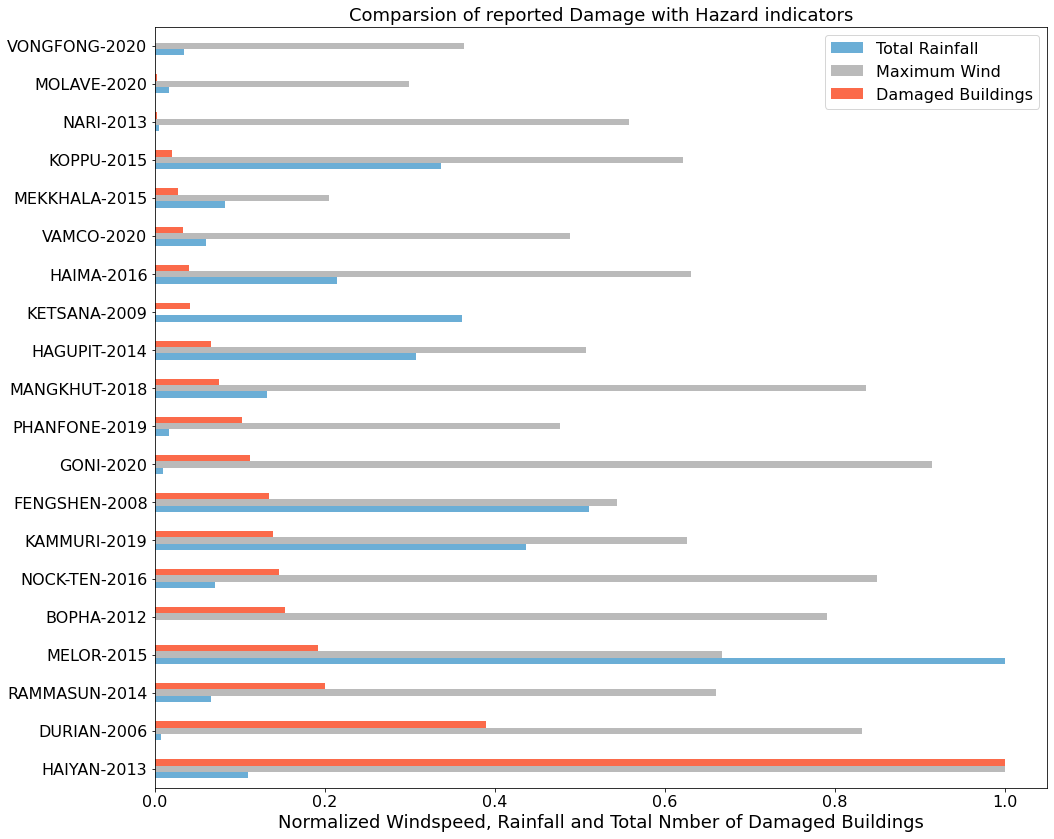

In [111]:
df_impact_hazard['typhoon_name']=df_impact_hazard['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_im_haz=df_impact_hazard[['typhoon_name','rainfall_Total','v_max','Totally']].groupby('typhoon_name').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='Totally',ascending=False).head(n=20)
 
def f(s):
    rmalized_df=(s-s.min())/(s.max()-s.min())
    return rmalized_df#s/s.max()

df_im_haz=df_im_haz[['rainfall_Total','v_max','Totally']].apply(f, axis=0)

df_im_haz.rename(columns={"rainfall_Total": "Total Rainfall", "v_max": "Maximum Wind", "Totally": "Damaged Buildings"},inplace=True)
df_im_haz
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16, 14))

 
df_im_haz.plot(ax=ax,kind='barh',color=['#6baed6','#bababa','#fb6a4a'])

ax.set_title('Comparsion of reported Damage with Hazard indicators',fontsize=18)
ax.set_xlabel('Normalized Windspeed, Rainfall and Total Nmber of Damaged Buildings',fontsize=18)
ax.set_ylabel('',fontsize=14)


fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)




#
    

In [121]:
df_total=pd.merge(df_impact_hazard, df_predisasters,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
df_total=df_total[df_total['v_max'].notnull()]
df_total=df_total[df_total['rainfall_max_6h'].notnull()] 
#df_total=df_total[df_total['dis_track_min']<100]
display(df_total)

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,Id,Year,Totally,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,durian2006,PH175101000,182.760714,14.716071,7.381696,55.032241,2.478142,30.0,2006.0,261.0,...,0.0,2.0,6.0,924,15074,16232,31306,3372.0,9337.0,8671.0
1,durian2006,PH045601000,159.666667,13.283333,6.165278,52.891105,41.386956,NaN,NaN,NaN,...,0.0,0.0,3.0,251,6415,6436,12851,594.0,1823.0,1723.0
2,durian2006,PH041001000,108.750000,8.154167,4.392708,51.137175,47.461548,NaN,NaN,NaN,...,1.0,3.0,2.0,199,18795,19264,38059,1463.0,4425.0,4125.0
3,durian2006,PH045602000,151.200000,12.147222,5.223611,36.574351,69.147636,NaN,NaN,NaN,...,0.0,1.0,1.0,264,7695,7935,15630,744.0,2397.0,2164.0
4,durian2006,PH043401000,125.975000,11.141667,5.156250,45.946435,58.003453,13.0,2006.0,30.0,...,2.0,4.0,22.0,225,23821,24038,47859,752.0,2336.0,2129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9098,noul2015,PH021525000,28.112500,4.772727,1.190426,38.632415,54.779271,1991.0,2015.0,3.0,...,3.0,2.0,2.0,226,9431,9607,19038,495.0,1556.0,1427.0
9099,noul2015,PH021527000,7.081250,0.665625,0.190625,30.610701,94.923153,NaN,NaN,NaN,...,2.0,8.0,6.0,1383,40577,41925,82502,2763.0,8441.0,8017.0
9100,noul2015,PH021529000,9.970000,1.126667,0.297500,30.567729,97.254184,NaN,NaN,NaN,...,17.0,10.0,14.0,470,77622,75880,153502,943.0,3408.0,3267.0
9101,noul2015,PH023137000,4.340000,0.327500,0.113542,34.884791,83.810138,NaN,NaN,NaN,...,2.0,2.0,6.0,811,33269,34381,67650,2556.0,8496.0,7926.0




###  Normalize data uisng population size or number of housing uints per manucipality (Calculate percentage per manucipality)

In [122]:

def division(x, y):
    try:
        value =100* (x / y)
        
    except:
        value = np.nan
    
    return 100 if value>100 else value


  

# Setting the new damage threshold

df_total["perc_dmg"] = df_total.apply(lambda x: division(x["Totally"], x["Housing Units"]), axis=1).values



df_total["vulnerable_groups"] = df_total.apply(lambda x: division(x["vulnerable_groups"], x["Total Pop"]), axis=1).values
df_total["pantawid_pamilya_beneficiary"] = df_total.apply(lambda x: division(x["Total # of Active HHs"], x["Housing Units"]), axis=1).values

df_total["Strong Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Strong Roof/Light Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Strong Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Light Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Light Roof/Light Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Light Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Salvaged Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Salvaged Roof/Light Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
df_total["Salvaged Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
 

### filter final data frame for only relevant features 

In [123]:
df_total=df_total.filter(['Mun_Code', 'typhoon', 'rainfall_Total', 'rainfall_max_6h',
                 'rainfall_max_24h', 'v_max', 'dis_track_min','landslide_per', 'stormsurge_per',
                 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
                 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 
                 'Yellow_per_LSbl', 'mean_slope','mean_elevation_m', 
                 'ruggedness_stdev', 'mean_ruggedness','slope_stdev',
                 'poverty_perc', 'with_coast', 'coast_length','Housing Units', 'Strong Roof/Strong Wall',
                 'Strong Roof/Light Wall', 'Strong Roof/Salvage Wall',
                 'Light Roof/Strong Wall', 'Light Roof/Light Wall',
                 'Light Roof/Salvage Wall', 'Salvaged Roof/Strong Wall',
                 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall',
                 'vulnerable_groups', 'pantawid_pamilya_beneficiary','perc_dmg'])


df_total.rename(columns ={"rainfall_Total":"HAZ_rainfall_Total",
                                     'rainfall_max_6h':'HAZ_rainfall_max_6h',
                                     'rainfall_max_24h':'HAZ_rainfall_max_24h',
                                     'v_max':'HAZ_v_max',
                                     'dis_track_min':'HAZ_dis_track_min',
                                     'binary_dmg':'DAM_binary_dmg',
                                     'perc_dmg':'DAM_perc_dmg',
                                    'landslide_per':'GEN_landslide_per',
                                    'stormsurge_per':'GEN_stormsurge_per',
                                    'Bu_p_inSSA':'GEN_Bu_p_inSSA',
                                    'Bu_p_LS':'GEN_Bu_p_LS',
                                     'Red_per_LSbldg':'GEN_Red_per_LSbldg',
                                    'Or_per_LSblg':'GEN_Or_per_LSblg',
                                     'Yel_per_LSSAb':'GEN_Yel_per_LSSAb',
                                    'RED_per_SSAbldg':'GEN_RED_per_SSAbldg',
                                     'OR_per_SSAbldg':'GEN_OR_per_SSAbldg',
                                    'Yellow_per_LSbl':'GEN_Yellow_per_LSbl',
                                     'mean_slope':'TOP_mean_slope',
                                    'mean_elevation_m':'TOP_mean_elevation_m',
                                     'ruggedness_stdev':'TOP_ruggedness_stdev',
                                    'mean_ruggedness':'TOP_mean_ruggedness',
                                     'slope_stdev':'TOP_slope_stdev',
                                     'poverty_perc':'VUL_poverty_perc',
                                    'with_coast':'GEN_with_coast',
                                     'coast_length':'GEN_coast_length',
                                     'Housing Units':'VUL_Housing_Units',
                                    'Strong Roof/Strong Wall':"VUL_StrongRoof_StrongWall",
                                    'Strong Roof/Light Wall':'VUL_StrongRoof_LightWall',
                                    'Strong Roof/Salvage Wall':'VUL_StrongRoof_SalvageWall',
                                    'Light Roof/Strong Wall':'VUL_LightRoof_StrongWall',
                                    'Light Roof/Light Wall':'VUL_LightRoof_LightWall',
                                    'Light Roof/Salvage Wall':'VUL_LightRoof_SalvageWall',
                                    'Salvaged Roof/Strong Wall':'VUL_SalvagedRoof_StrongWall',
                                    'Salvaged Roof/Light Wall':'VUL_SalvagedRoof_LightWall',
                                    'Salvaged Roof/Salvage Wall':'VUL_SalvagedRoof_SalvageWall',
                                    'vulnerable_groups':'VUL_vulnerable_groups',
                                    'pantawid_pamilya_beneficiary':'VUL_pantawid_pamilya_beneficiary'},inplace=True)

df_total = df_total.filter([
    'typhoon',
     'HAZ_rainfall_Total',
     'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    'GEN_Bu_p_inSSA', 
    'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    'TOP_mean_ruggedness',
    'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary',
    'DAM_perc_dmg'])


In [124]:
len(df_total)

9103

### save final dataframe for model input

In [125]:
df_total.to_csv("data/model_input/combined_input_data.csv", index=False)

In [126]:
np.mean(df_total["DAM_perc_dmg"])

5.88002328898155

In [127]:
df_total=df_total[df_total["DAM_perc_dmg"].notnull()]

In [128]:
np.mean(df_total["DAM_perc_dmg"])

5.88002328898155